# **[4] Hierarchical Sampling**
## **1 Hierarchical Sampling이란?**
- Coarse 네트워크의 인풋 데이터인 $z$(개수: $\text{N Samples}_\text{Coarse}$)라 합시다.
- Fine 네트워크는 이 값들 중 **물체가 존재할 확률이 높은 구간** 에서 더 많은 샘플링을 진행하는데, 이 것이 **Hierarchical Sampling** 입니다.
- 이때, **확률밀도함수(PDF)** 와 **누적확률함수(CDF)** 를 해당 구간을 파악합니다.
- 실제로 코드 상에서는 세부분할할 깊이 값으로 **$z$값들의 중간 지점들 (개수: $\text{N Samples}_\text{Coarse} - 1 = M$)** 이 들어갑니다.

## **2 가중치 기반 확률밀도함수 (PDF, Probability Density Function)**

- **수식**:  
  $$
    P(a \le X \le b) = \int_{a}^{b} f(x)\, dx.
  $$ 
  - 이는 **연속 분포**에 대한 확률밀도함수이나, 샘플 포인트는 **이항 분포**를 따르므로 아래의 수식을 코드로 구현하여 사용합니다.
  $$
    \text{pdf}(x_i) = \frac{w_i}{\sum_j w_j}.
  $$
  - 즉, **가중치가 클수록 PDF 값도 커지며, 중요한 영역에서 샘플이 더 집중적으로 생성**됩니다.
- **코드**:  
  - 코드에서는 `weights / torch.sum(weights, -1, keepdim=True)`로 구현됩니다.

## **3 누적확률함수 (CDF, Cumulative Distribution Function)**

- **수식**:  
  $$
  \text{CDF}(x) = P(X \le x) = \int_{-\infty}^{x} \text{pdf}(t)\, dt.
  $$ 
  - 이 또한 **연속 분포**에 대한 누적확률함수이므로, 실제로는 아래와 같은 **이항 분포**에 대한 수식을 사용합니다.
  $$
    \text{cdf}(x_k) = \sum_{j=1}^{k} \text{pdf}(x_j).
  $$ 
  - CDF는 **0에서 1 사이의 값으로 정규화**되며, **각 샘플 위치까지의 누적 확률을 의미**합니다.
  - CDF의 형태는 항상 **단조 증가**하며, **큰 weights를 가지는 영역** 에서는 **더 빠르게 증가**합니다.
- **코드**:  
  - 코드에서는 `torch.cumsum(pdf, dim=-1)`로 구현됩니다.
  - 마지막에 `torch.cat([torch.zeros_like(cdf[..., :1]), cdf], dim=-1)`을 적용하여, **맨 앞에 0을 추가**해 $\text{cdf}(x_1) = 0$ 형태가 되도록 설정합니다.

## **4 Fine 모델을 위한 역변환 샘플링 (Inverse Transform Sampling)**

Fine 모델에 전달할 추가 샘플을 얻기 위해 **역변환 샘플링 (Inverse Transform Sampling)** 을 수행합니다.  
구체적인 과정은 다음과 같습니다:

1. **균등 분포에서 새로운 샘플 $u$생성**
   - $u \sim U(0,1)$를 따르는 $\text{N Samples}_\text{Fine}$개의 무작위 샘플 $u$를 생성합니다.

2. **CDF 역변환을 이용하여 새로운 $z$값 샘플링**
   - $u$를 coarse 샘플의 CDF 값들에 매핑하여 새로운 샘플링 위치 $z_{\text{fine}}$을 찾습니다.
   - 이를 위해, **CDF에서 $u$가 위치한 구간**을 찾고, 이를 **선형 보간**하여 새로운 $z$값을 얻습니다.
   - `torch.searchsorted(cdf, u)`를 사용하여 $u$가 위치한 CDF 구간을 찾을 수 있습니다.

3. **최종 샘플링된 $z$값**
   - 기존 coarse 샘플 $z_{\text{vals}}$과 새롭게 샘플링된 $z_{\text{fine}}$을 합쳐서, **최종적으로 fine 모델에 전달할 $z$값**을 얻습니다.

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from adjustText import adjust_text

#---------------------
# torch.searchsorted
#---------------------
# “정렬된 1D 텐서(예: cdf) 내에서 u 값이 들어갈 인덱스”를 찾는 함수.
# 매개변수 right=True면, 동일값이면 오른쪽 인덱스 반환.
cdf_1d = torch.tensor([0.0, 0.2, 0.5, 0.8, 1.0])  # shape (5,)
u_1d = torch.tensor([0.1, 0.7, 0.9])             # shape (3,)

inds = torch.searchsorted(cdf_1d, u_1d, right=True)
# cdf_1d: 0.0, 0.2, 0.5, 0.8, 1.0
# u_1d:   0.1 -> index=1 (cdf[1]=0.2)
#         0.7 -> index=3 (cdf[2]=0.5, cdf[3]=0.8)
#         0.9 -> index=4 (cdf[4]=1.0)
# inds = [1, 3, 4]


#--------------------
# torch.gather
#--------------------
# “특정 인덱스(inds) 위치에서 값을 가져오기”
# shape가 (N_rays, N_samples)인 텐서 cdf, 그리고 (N_rays, K)인 인덱스 inds가 있을 때,
# gather로 “각 배치마다 K개 인덱스 위치”를 모아서 shape (N_rays,K) 결과를 얻는다.
cdf_2d = torch.tensor([
  [0.0, 0.2, 0.5, 1.0],
  [0.0, 0.4, 0.6, 1.0]
])  # shape (2,4)

inds_2d = torch.tensor([
  [1,3],
  [0,2]
])  # shape (2,2)

# gather(cdf_2d, dim=1, index=inds_2d)
cdf_g = torch.gather(cdf_2d, 1, inds_2d)
# result shape (2,2).
# cdf_g[0] = [ cdf_2d[0,1], cdf_2d[0,3] ] = [0.2,1.0]
# cdf_g[1] = [ cdf_2d[1,0], cdf_2d[1,2] ] = [0.0,0.6]

In [ ]:
def sample_pdf(bins, weights, N_samples, det=False, pytest=False):
    """
    Importance Sampling으로 새로운 샘플의 z좌표(또는 깊이)를 뽑아내는 함수.

    [배경]
    --------------------------------------------------------------------------------------
    - NeRF에서 코스(coarse) 레이어의 샘플 지점들로부터 "weights"(= a_i * T_i)를 구하고,
      이를 확률분포 함수(pdf)로 삼아 더 많은 샘플을 "중요도 있게" 추가(fine 모델)하려고 함.
    - 이 함수는 'Inverse Transform Sampling' 기법을 사용:
      1) weights -> pdf -> cdf
      2) uniform random (u) -> cdf^-1(u)
      3) -> 새 z샘플(점) 추출

    [입력 설명]
    --------------------------------------------------------------------------------------
    - bins : shape (N_rays, Coarse Model's N_samples - 1) = (N_rays, M) 
        코스(coarse) 모델에 입력된 샘플 포인트들(z_vals)의 중간 지점들인 z_vals_mid
        * 실제론 'z_vals의 중간점'이지만, 구현 편의상 "bins"라 부름.
          코스 모델의 N_samples 사이의 중간값들이므로 N_samples - 1개 존재 (이하 N_samples - 1 = M으로 칭함)

    - weights: raw2outputs 함수에서 계산한 샘플별 가중치 (a_i * T_i) (N_rays, corase 모델의 N_samples)
               이 때, smaple_pdf 함수에 넘겨지는 인자는 맨앞, 맨뒤 시작점을 절삭해
               weighs[..., 1: -1]로 (N_rays, corase 모델의 N_samples - 2) = (N_rays, M - 1)

    - N_samples: fine 모델에서 새로 추출할 샘플 개수 (Coarse Model의 N_samples와 다름에 유의!)

    - det : bool
        True면 '균등분할'에 따라 deterministic하게 샘플 (테스트 등),
        False면 실제로 랜덤하게 뽑음.

    - pytest : bool
        True면 난수를 고정(np.random.seed(0))시켜 테스트 재현 가능.

    [출력]
    --------------------------------------------------------------------------------------
    - samples : shape (N_rays, N_samples)
        각 레이마다 새롭게 샘플링된 z 좌표. (importance sampling 결과)
    """

    # (1) weights에 작은 수(1e-5)를 더해 NaN 방지
    weights = weights + 1e-5 # prevent nans

    # torch.sum(weights, -1): (N_rays, )
    # torch.sum(weights, -1, keepdim=True): (N_rays, 1)
    pdf = weights / torch.sum(weights, -1, keepdim=True)
    # pdf: (N_rays, M - 1)

    cdf = torch.cumsum(pdf, -1) # 마지막 차원 기준 누적합으로 업데이트 (N_rays, M - 1)
    cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], -1)  #맨 앞 지점의 누적 확률인 0을 concat -> (N_rays, M)
    # cdf: (N_rays, M)

    # Take uniform samples
    # cdf에서 추출할 임의의 점의 y값이 될 u를 0부터 1까지의 값으로 생성
    if det: # u를 0부터 1까지 균등 분할
        u = torch.linspace(0., 1., steps=N_samples) # (N_samples, )
        u = u.expand(list(cdf.shape[:-1]) + [N_samples]) # (N_rays, N_samples)
    else: # u를 0부터 1까지 랜덤하게 추출
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples])
    # u: (N_rays, N_samples)

    # Pytest, overwrite u with numpy's fixed random numbers
    if pytest:
        np.random.seed(0)
        new_shape = list(cdf.shape[:-1]) + [N_samples]
        if det:
            u = np.linspace(0., 1., N_samples)
            u = np.broadcast_to(u, new_shape)
        else:
            u = np.random.rand(*new_shape)
        u = torch.Tensor(u)

    # Invert CDF
    # weight에 따라 샘플링을 잦게 한다.
    u = u.contiguous()
    inds = torch.searchsorted(cdf, u, right=True)
    # cdf 함수의 특징
    # 1. 단조증가 함수이므로 정렬된 자료에만 쓸 수 있는 seachsorted() 함수를 사용해 y = u에와 대응하는 단 하나의 x값을 가짐.
    # 2. 0부터 1까지의 값을 가지므로 모든 y = u에 일대일 대응하는 x값을 가짐.
    # inds: y = u와 y=cdf의 교점의 x좌표 집합 (N_rays, N_samples)

    # 인덱스들의 최대 한계
    below = torch.max(
        torch.zeros_like(inds-1), # inds-1과 같은 차원의 0으로 이루어진 텐서
        inds-1 # inds의 모든 원소에서 1을 뺀 값.
    )
    # 이 두 텐서 중 최대 값을 골라 (inds[i,k]-1)이 음수가 될 수 있으면(예: inds=0 → inds-1=-1), 그것을 0으로 클램프(clamp)하는 효과.

    above = torch.min(
        # cdf.shape[-1] = M
        # cdf.shape[-1]-1: M - 1 (즉 최고 인덱스)
        (cdf.shape[-1]-1)*torch.ones_like(inds), # 차원이 inds와 동일하고, 모든 원소가 최고 인덱스로 이루어진 텐서
        inds # 실제 인덱스 텐서
    )
    # 이 둘 중 최소값을 골라냄

    # below: (N_rays, N_samples) … “구간 하한 인덱스”.
    # above: (N_rays, N_samples) … “구간 상한 인덱스”.
    # 이 두 텐서(below[i,k], above[i,k])는, i번째 광선, k번째 샘플에 대해 CDF 상에서 “인접 두 인덱스 (lower, upper)”를 담고 있음.
    # 예) inds = 1: below = 0, above = 1
    # 예) inds = 0: below = 0, above = 0

    inds_g = torch.stack([below, above], -1)
    # <shape>
    # below.shape = (N_rays, N_samples)
    # above.shape = (N_rays, N_samples)
    # torch.stack([...], -1) → 마지막 축(-1)에 2개를 쌓음.
    # ⇒ inds_g.shape = (N_rays, N_samples, 2).

    # <세부 구분>
    # inds_g[i,k,0] = below[i,k]
    # inds_g[i,k,1] = above[i,k]
    
    # inds_g에 해당하는 cdf, bin값을 얻는다.
    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]] # [N_rays, N_samples, M]의 리스트.
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    # cdf: (N_rays, M)
    # cdf.unsqueeze(1): (N_rays, 1, M)
    # cdf.unsqueeze(1).expand(matched_shape): (N_rays, N_samples, M)
    # inds_g: (N_rays, N_samples, 2)
    # torch.gather(...): 해당 함수를 사용할 수 있도록 cdf의 1, 2차원을 맞춰준 뒤, 3차원에 대하여 inds_g의 인덱스에 해당하는 값 두 개(하한, 상한)을 뽑아온다.

    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)
    # inds_g의 인덱스에 해당하는 bins 값을 상한, 하한으로 가져온다.
    # 즉, 특정 값 u를 포함하는 cdf(i), cdf(i + 1)과 bins(i), bins(i + 1)을 각각 cdf_g, bins_g에 담는다.

    denom = (cdf_g[...,1]-cdf_g[...,0]) #below와 above의 차이를 분모로 사용한다
    denom = torch.where(denom<1e-5, torch.ones_like(denom), denom) # denom이 너무 작아지면 분자를 1로 두도록
    t = (u-cdf_g[...,0])/denom # 분자는 u에서 below를 뺀 값
    # 즉, t = cdf(i)에서 u까지의 증가량 / cdf(i)에서 cdf(i + 1) 까지의 증가량
    samples = bins_g[...,0] + t * (bins_g[...,1]-bins_g[...,0])
    # 이 증가량을 bins(i)부터 bins(i + 1)까지의 증가량에 곱하여 선형적인 비율을 구한 후 bins (i)에 더해준다.
    # 이로써 u가 정확히 어디 있는지 파악

    return samples

============================== Variable Value ==============================
cdf        tensor([0.0000, 0.0500, 0.9500, 1.0000])
u          tensor([0.4663, 0.4623, 0.1814, 0.0709, 0.8433, 0.1471])
inds       tensor([2, 2, 2, 2, 2, 2])

below      tensor([1, 1, 1, 1, 1, 1])
above      tensor([2, 2, 2, 2, 2, 2])

cdf_below  tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500])
cdf_above  tensor([0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500])
bins_below tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000])
bins_above tensor([4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000])

denom      tensor([0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000])
t          tensor([0.4625, 0.4581, 0.1459, 0.0233, 0.8814, 0.1079])
samples    tensor([3.9625, 3.9581, 3.6459, 3.5233, 4.3814, 3.6079])


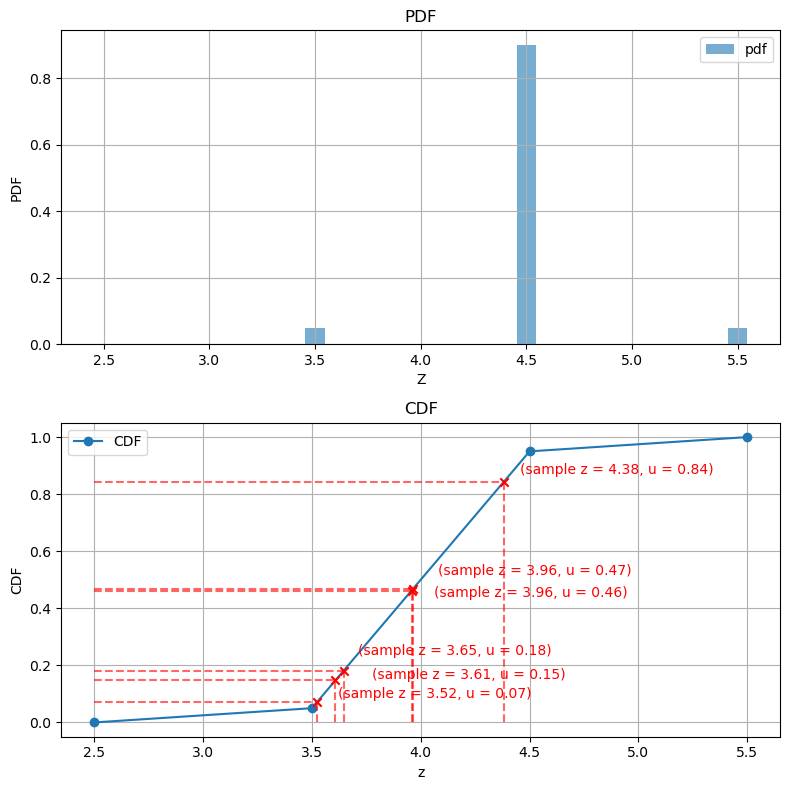

samples: tensor([3.9625, 3.9581, 3.6459, 3.5233, 4.3814, 3.6079])


In [ ]:
def sample_pdf_debug(bins, weights, N_samples=5, det=False, do_plot=False):
    """
    Args:
      bins:  (M,)  구간 경계(또는 중간점) 좌표
      weights: (M-1,) 각 구간에 대한 가중치
      N_samples: 새로 뽑을 샘플 개수
      det: True면 균등분할, False면 난수
      do_plot: True면 matplotlib 그래프를 표시

    Returns:
      samples: (N_samples,) shape
        새로 샘플링된 z좌표
    """

    # -------------------------------------------------------------------------
    # 1) weights -> pdf -> cdf
    # -------------------------------------------------------------------------
    # 작은 숫자 더해 NaN 회피
    weights = weights + 1e-5
    pdf = weights / weights.sum()     # pdf = weights / sum(weights) (M-1,)

    # cdf는 pdf 누적합 => shape (M-1,)
    cdf = torch.cumsum(pdf, dim=0)    # (M-1,)
    # 맨 앞에 0을 붙여 (M,)로 확장
    cdf = torch.cat([torch.zeros(1), cdf], dim=0)  # (M,)

    # -------------------------------------------------------------------------
    # 2) uniform 샘플(u) 생성
    # -------------------------------------------------------------------------
    if det: # 균등하게 0~1 분할하여 샘플링
        u = torch.linspace(0., 1., steps=N_samples)
    else: # 난수 샘플링
        u = torch.rand(N_samples)  # (N_samples,)

    # -------------------------------------------------------------------------
    # 3) searchsorted(cdf, u) -> inds
    #    => u가 cdf의 어느 구간에 속하는지 인덱스
    # -------------------------------------------------------------------------
    # inds: 각 u에 대해 cdf 어디 구간인지
    inds = torch.searchsorted(cdf, u, right=True)
    # print(f"{'Variable':<10} {'Values'}")
    print("=" * 30, "Variable Value", "=" * 30)
    print(f"{'cdf':<10} {cdf}")
    print(f"{'u':<10} {u}")
    print(f"{'inds':<10} {inds}", end = "\n\n")
    # => inds: u가 cdf의 몇 번째 인덱스로 삽입될 수 있는가

    # 하한 인덱스, 상한 인덱스
    below = torch.clamp(inds - 1, min=0)
    above = torch.clamp(inds, max=cdf.shape[0]-1)
    print(f"{'below':<10} {below}")
    print(f"{'above':<10} {above}", end = "\n\n")

    # -----------------------------
    # 4) cdf, bins에서 아래/위 값
    # -----------------------------
    cdf_below = cdf[below]  # (N_samples,)
    cdf_above = cdf[above]  # (N_samples,)
    bins_below = bins[below]  # (N_samples,)
    bins_above = bins[above]  # (N_samples,)
    print(f"{'cdf_below':<10} {cdf_below}")
    print(f"{'cdf_above':<10} {cdf_above}")
    print(f"{'bins_below':<10} {bins_below}")
    print(f"{'bins_above':<10} {bins_above}", end = "\n\n")

    # 0나눗셈 회피
    denom = (cdf_above - cdf_below)
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    print(f"{'denom':<10} {denom}")

    # 선형 보간
    t = (u - cdf_below) / denom
    print(f"{'t':<10} {t}")
    samples = bins_below + t * (bins_above - bins_below)
    print(f"{'samples':<10} {samples}")
    # => (N_samples,)

    # -----------------------------
    # (옵션) 그래프 디버그
    # -----------------------------
    if do_plot:
        bins_np = bins.detach().cpu().numpy()
        pdf_np  = pdf.detach().cpu().numpy()   # (M-1,)
        cdf_np  = cdf.detach().cpu().numpy()   # (M,)
        u_np    = u.detach().cpu().numpy()     # (N_samples,)
        samp_np = samples.detach().cpu().numpy()

        # figure
        plt.figure(figsize=(8,8))

        # (A) 상단 subplot: PDF vs midpoints
        ax1 = plt.subplot(2,1,1)
        plt.title("PDF")
        width = (bins_np[-1] - bins_np[0]) * 0.03  # bar 너비 대략
        plt.bar(bins_np, np.insert(pdf_np, 0, 0), width=width, alpha=0.6, label='pdf')
        # bins_np (M, 1)이므로, pdf_np를 동일 차원으로 맞춰주기 위해 0번 인덱스에 0의 값을 추가
        plt.xlabel("Z")
        plt.ylabel("PDF")
        plt.legend()
        plt.grid(True)

        # (B) 하단 subplot: CDF vs bins + 샘플 표시
        ax2 = plt.subplot(2,1,2)
        plt.title("CDF")

        # cdf 라인: x=bins_np, y=cdf_np
        plt.plot(bins_np, cdf_np, '-o', label='CDF')

        # 텍스트 리스트 저장
        texts = []

        # u_i 값마다, 수평선 y=u_i, 교차점 x=samp_i
        # 교점 시각화(수직선+수평선+점)
        for k in range(N_samples):
            yk = u_np[k]     # u의 y 좌표
            xk = samp_np[k]  # u의 y 좌표와 CDF 함수가 만나는 교점의 x 좌표

            # 수평선: y=yk, x from bins[0] to xk
            ax2.hlines(yk, bins_np[0], xk, color='red', linestyles='dashed', alpha=0.6)
            # 수직선: x=xk, y from 0 to yk
            ax2.vlines(xk, 0, yk, color='red', linestyles='dashed', alpha=0.6)
            # 교점(X)
            ax2.scatter([xk],[yk], color='red', marker='x', zorder=5)
            # 좌표 표시
            text = ax2.text(xk, yk, f"(sample z = {xk:.2f}, u = {yk:.2f})", fontsize=10, ha='left', va='bottom', color='red')
            texts.append(text)

        adjust_text(texts, ax=ax2, expand_points=(2, 2), force_points=(0.2, 0.2))
        plt.ylim([-0.05, 1.05])
        plt.xlabel("z")
        plt.ylabel("CDF")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return samples


# 테스트 / 예시
if __name__ == "__main__":
    # bins = (M,) => 여기서 M=4
    # => 실제 구간 4개 => weights.shape=(4,)

    # bins: z 구간 경계
    bins_example = torch.tensor([2.5, 3.5, 4.5, 5.5], dtype=torch.float32)  # (4,)

    # weights: bins 사이의 구간 3개 => shape=(3,)
    weights_example = torch.tensor([0.05, 0.90, 0.05], dtype=torch.float32)

    samples = sample_pdf_debug(bins_example, weights_example, N_samples=6,
                                det=False, do_plot=True)
    print("samples:", samples)
